# 1. 라이브러리 & 데이터 준비

In [37]:
!pip install pwlf

In [38]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.linear_model import LinearRegression, HuberRegressor, RANSACRegressor, TheilSenRegressor
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import PolynomialFeatures
from sklearn.metrics import mean_squared_error, r2_score
from sklearn.pipeline import make_pipeline
import pwlf

In [39]:
data = pd.read_csv("/content/hw3_data_2.csv")
print("전체 데이터 개수:", len(data))

X = data['x'].values.reshape(-1, 1)
y = data['y']

전체 데이터 개수: 250


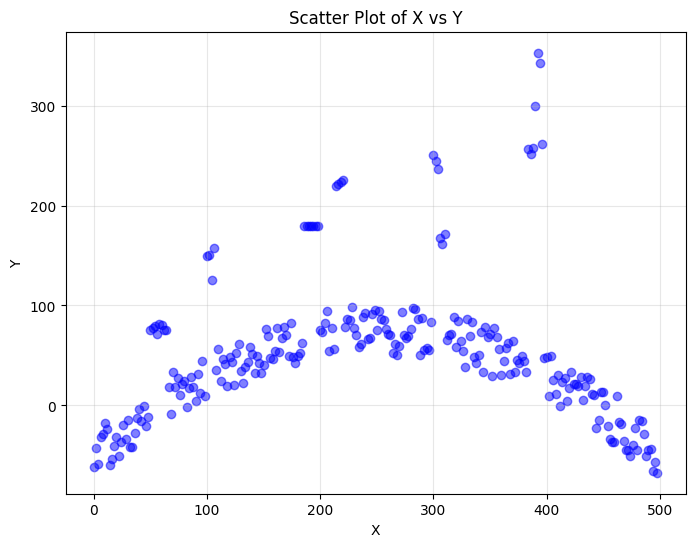

In [40]:
plt.figure(figsize=(8, 6))
plt.scatter(X, y, color="blue", alpha=0.5)
plt.xlabel("X")
plt.ylabel("Y")
plt.title("Scatter Plot of X vs Y")
plt.grid(True, alpha=0.3)
plt.show()

# 2.  Linear Regression with Outliers

In [41]:
lr = LinearRegression().fit(X, y)
hr = HuberRegressor().fit(X, y)
rr = RANSACRegressor().fit(X, y)
tsr = TheilSenRegressor().fit(X, y)
models = {
    "Linear": (lr, "blue"),
    "Huber": (hr, "darkorange"),
    "RANSAC": (rr, "green"),
    "Theil-Sen": (tsr, "red")
}

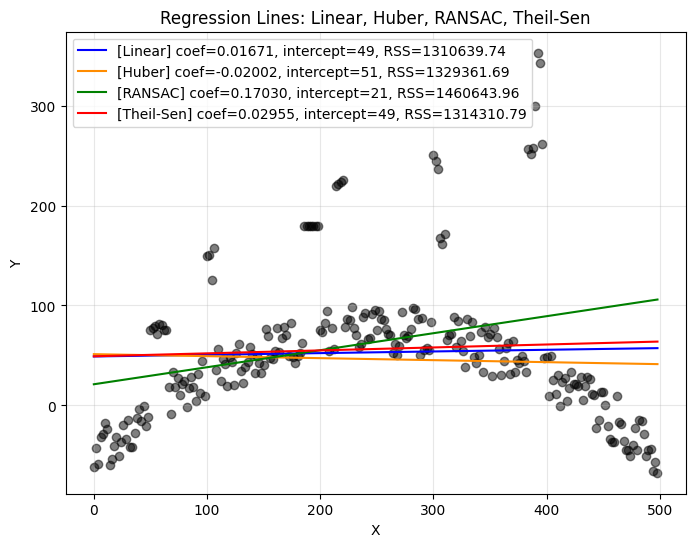

In [42]:
plt.figure(figsize=(8, 6))

for name, (model, color) in models.items():
    y_pred = model.predict(X)
    rss = np.sum((y - y_pred) ** 2)

    if name != "RANSAC":
      coef =  model.coef_[0]
      intercept = model.intercept_
    else:
      coef = model.estimator_.coef_[0]
      intercept = model.estimator_.intercept_

    label = f"[{name}] coef={coef:.5f}, intercept={intercept:.0f}, RSS={rss:.2f}"
    plt.plot(X, y_pred, color=color, label=label)

plt.scatter(X, y, color="black", alpha=0.5)
plt.xlabel("X")
plt.ylabel("Y")
plt.title("Regression Lines: Linear, Huber, RANSAC, Theil-Sen")
plt.grid(True, alpha=0.3)
plt.legend()
plt.show()

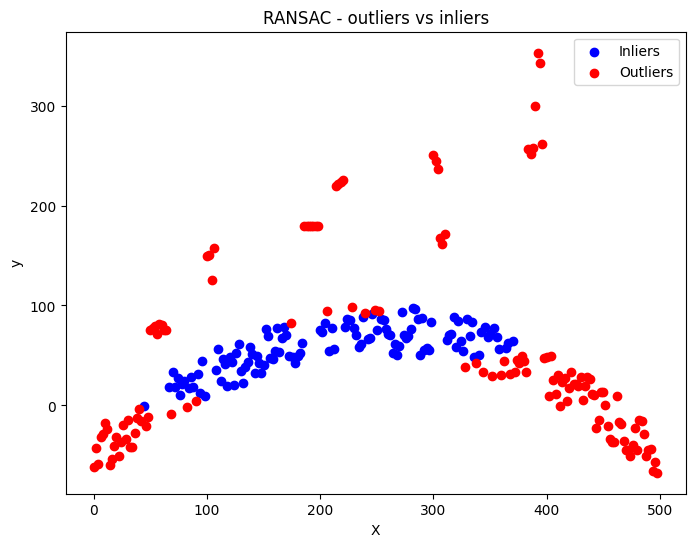

In [43]:
inlier_mask = rr.inlier_mask_
outlier_mask = np.logical_not(inlier_mask)

plt.figure(figsize=(8, 6))
plt.scatter(X[inlier_mask], y[inlier_mask], color='blue', label='Inliers')
plt.scatter(X[outlier_mask], y[outlier_mask], color='red', label='Outliers')

plt.title('RANSAC - outliers vs inliers')
plt.xlabel('X')
plt.ylabel('y')
plt.legend()
plt.show()

# 3. Nonlinear Regression with Outliers

### (1) Polynomial Regression

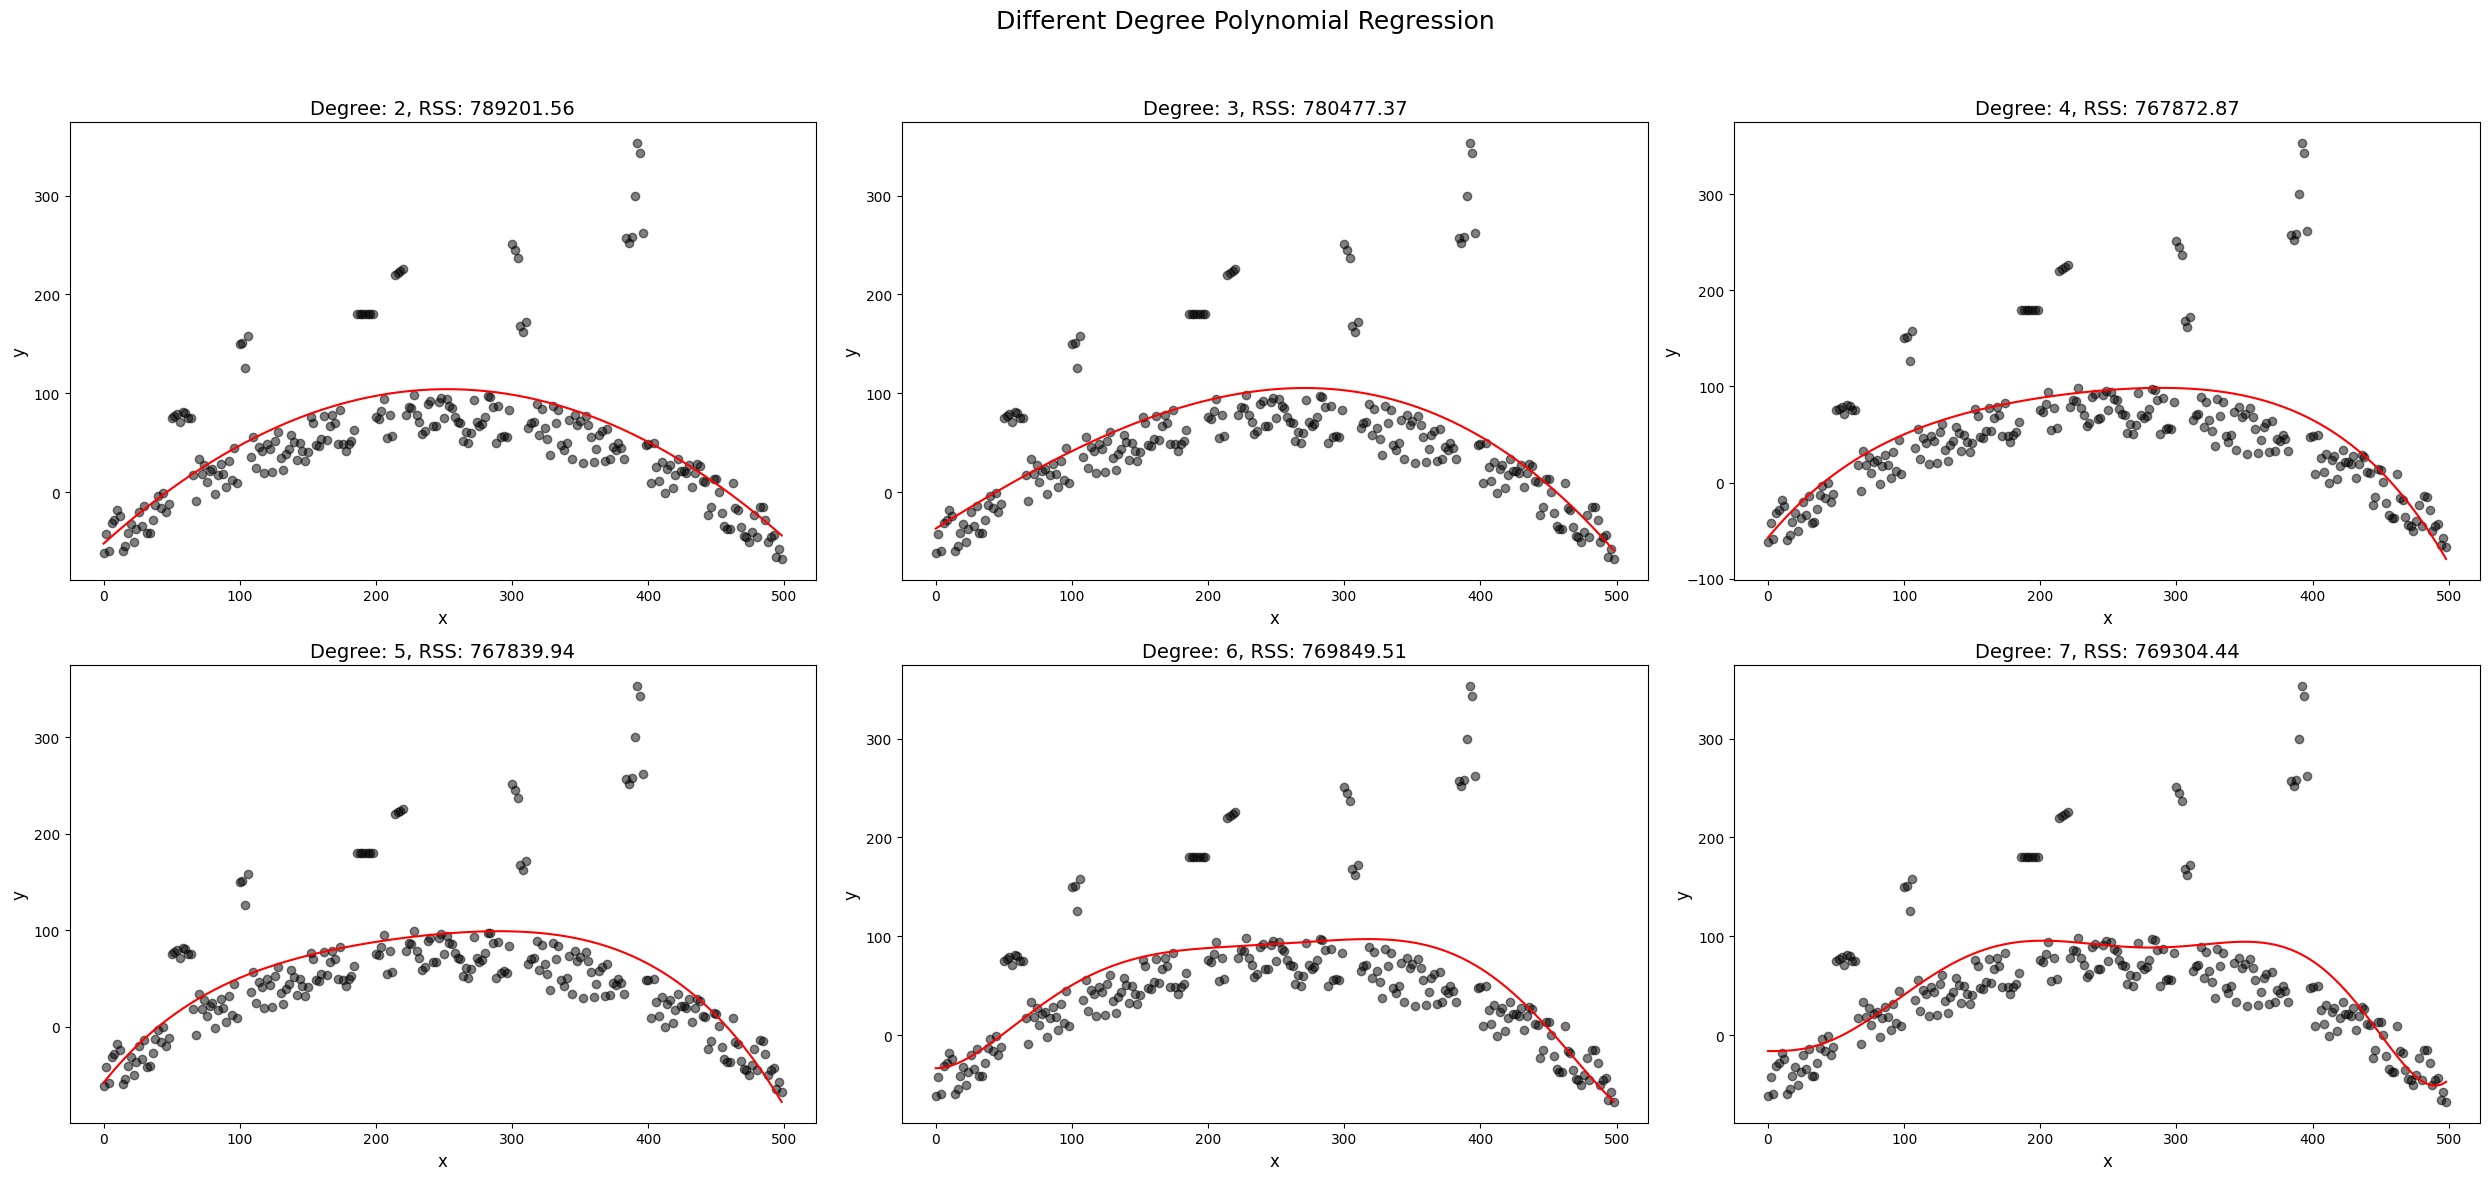

In [44]:
fig, axs = plt.subplots(2, 3, figsize=(25, 12))

for ax, degree in zip(axs.flatten(), range(2, 8)):
    poly_model = make_pipeline(PolynomialFeatures(degree), LinearRegression())
    poly_model.fit(X, y)

    y_train_pred = poly_model.predict(X)
    rss = np.sum((y - y_train_pred) ** 2)

    ax.scatter(X, y, color='black', alpha=0.5)
    ax.plot(X, y_train_pred, color='red')

    ax.set_title(f"Degree: {degree}, RSS: {rss:.2f}", fontsize=14)
    ax.set_xlabel('x', fontsize=12)
    ax.set_ylabel('y', fontsize=12)

fig.suptitle("Different Degree Polynomial Regression", fontsize=18)
plt.tight_layout(rect=[0, 0, 1, 0.95])
plt.show()

### (2) Piecewise Lienar Regression

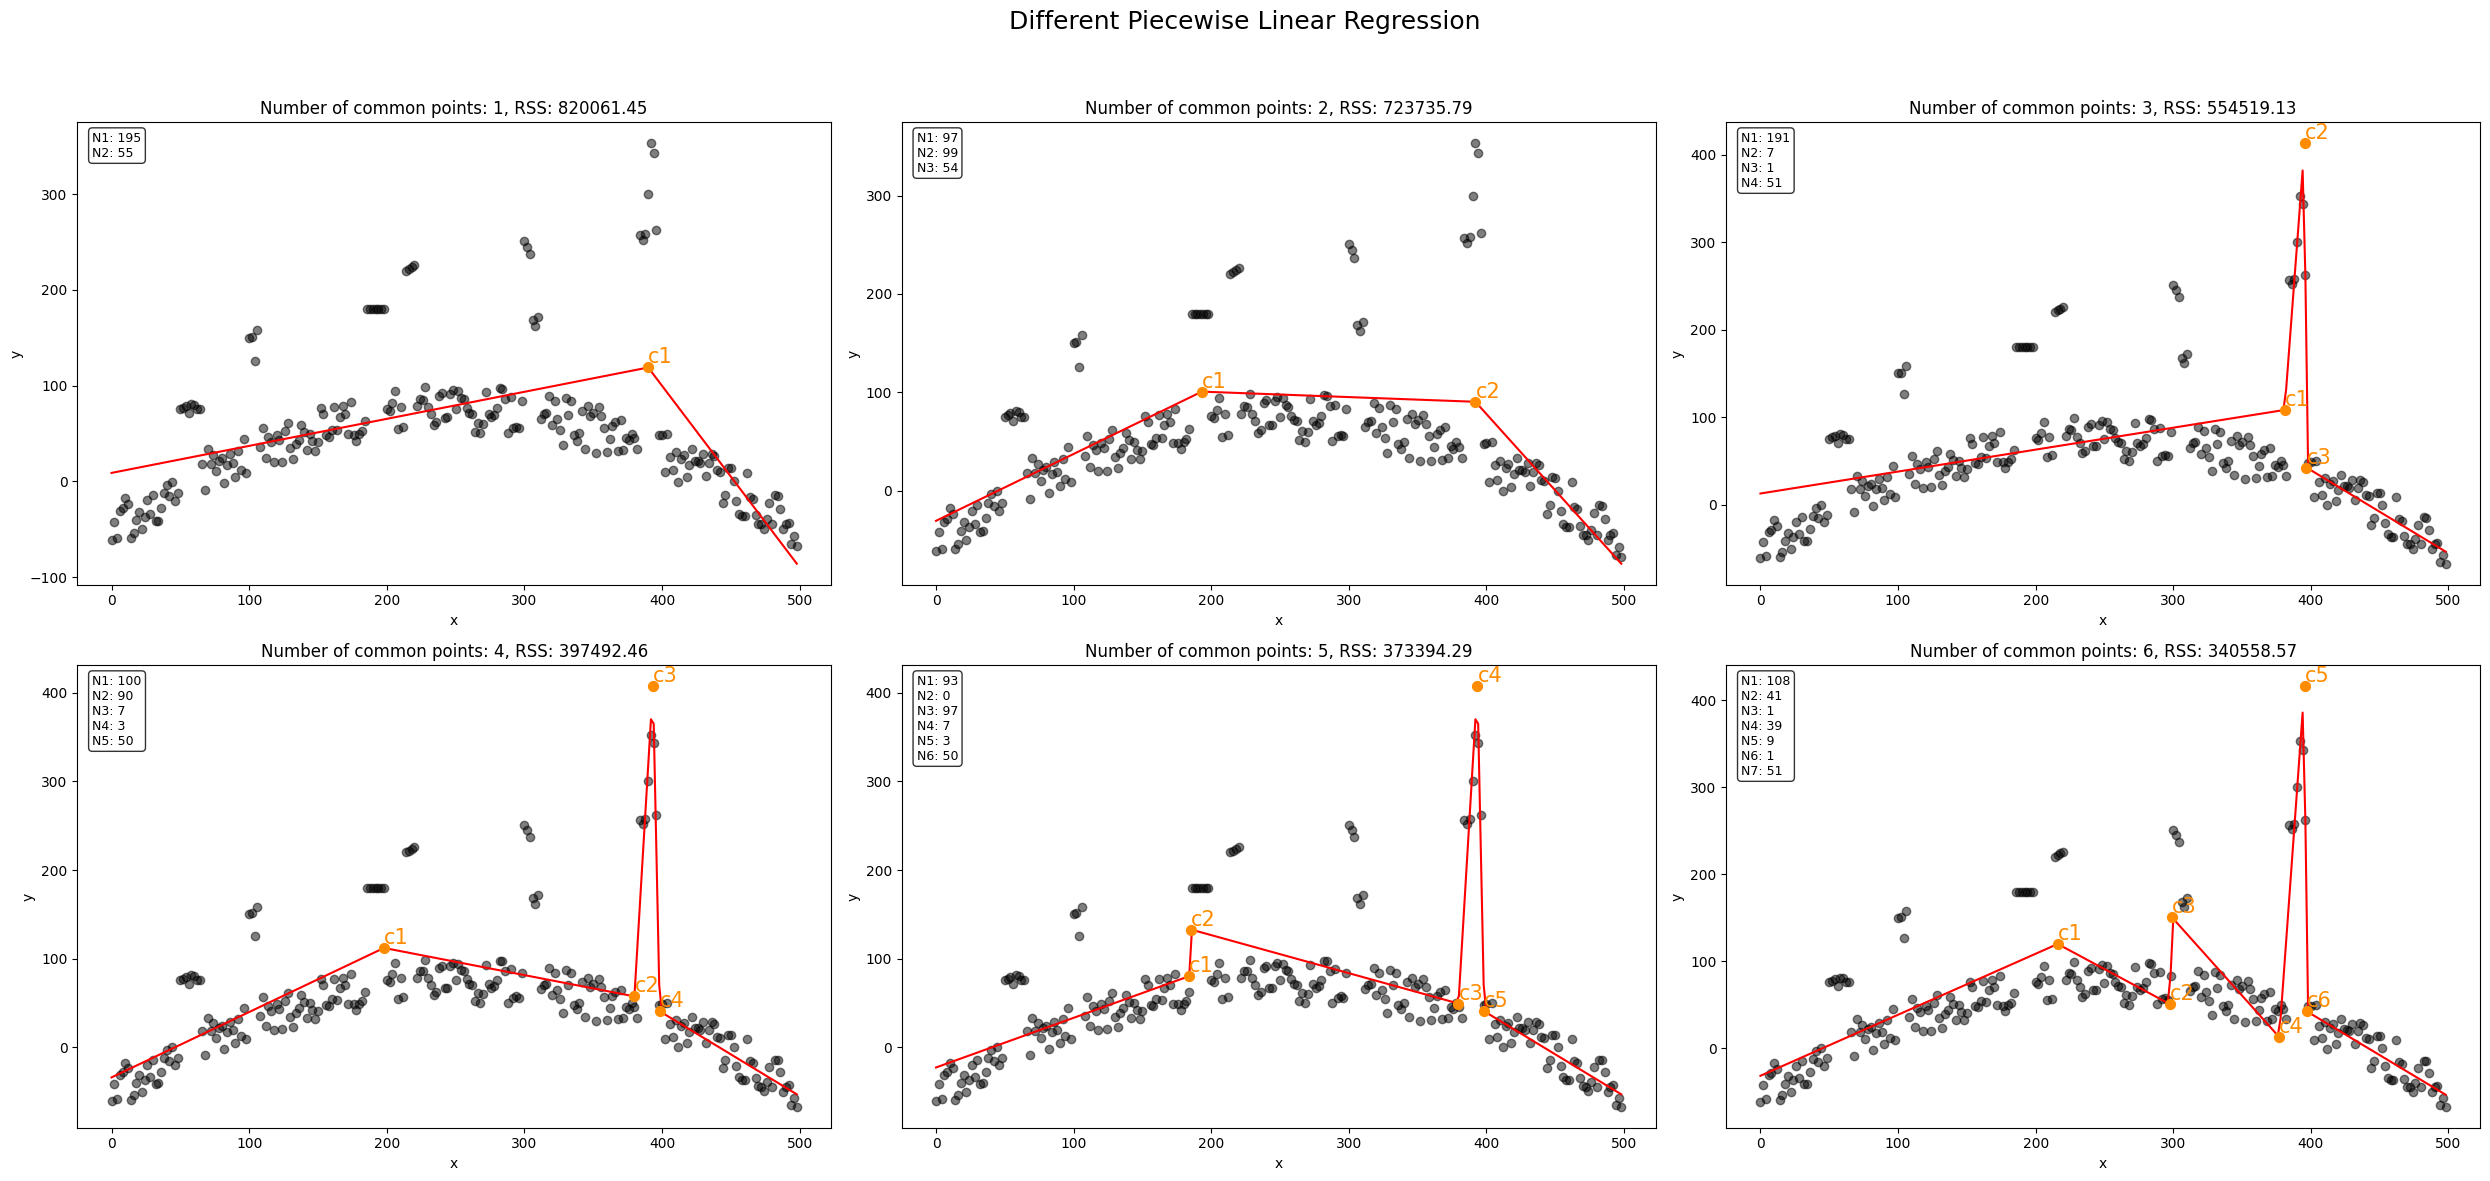

In [45]:
X_reshape = X.reshape(-1)
model = pwlf.PiecewiseLinFit(X_reshape, y)

fig, axs = plt.subplots(2, 3, figsize=(25, 12))
for ax, num_segments in zip(axs.flatten(), range(2, 8)):
    breakpoints = model.fit(num_segments)
    predictions = model.predict(X_reshape)

    residuals = y - predictions
    RSS = np.sum(residuals ** 2)

    segment_counts = np.histogram(X_reshape, bins=breakpoints)[0]

    ax.plot(X_reshape, predictions, color='red')
    ax.scatter(X_reshape, y, color='black', alpha=0.5)

    for i, bp in enumerate(breakpoints[1:-1]):
        ax.scatter(bp, model.predict([bp]), color='darkorange', s=50, zorder=5)
        ax.text(bp, model.predict([bp]), f'c{i+1}', color='darkorange', fontsize=15, verticalalignment='bottom')

    ax.set_title(f'Number of common points: {num_segments-1}, RSS: {RSS:.2f}')
    ax.set_xlabel('x')
    ax.set_ylabel('y')

    textstr = "\n".join([f'N{i+1}: {count}' for i, count in enumerate(segment_counts)])
    ax.text(0.02, 0.98, textstr, transform=ax.transAxes, fontsize=9, verticalalignment='top', bbox=dict(boxstyle='round', facecolor='white', alpha=0.8))

fig.suptitle("Different Piecewise Linear Regression", fontsize=18)
plt.tight_layout(rect=[0, 0, 1, 0.95])
plt.show()

### (3) Moving Least Squares Regression

In [46]:
def gaussian_weights(x, x0, sigma=1.0):
    return np.exp(-((x - x0) ** 2) / (2 * sigma ** 2))

def moving_least_squares(x, y):
    x_dense = np.linspace(x.min(), x.max(), 500)
    y_dense = []

    for x0 in x_dense:
        weights = gaussian_weights(x, x0)

        W = np.diag(weights)

        A = np.vstack([x, np.ones(len(x))]).T
        coeffs = np.linalg.inv(A.T @ W @ A) @ (A.T @ W @ y)

        y0 = coeffs[0] * x0 + coeffs[1]
        y_dense.append(y0)

    return x_dense, np.array(y_dense)

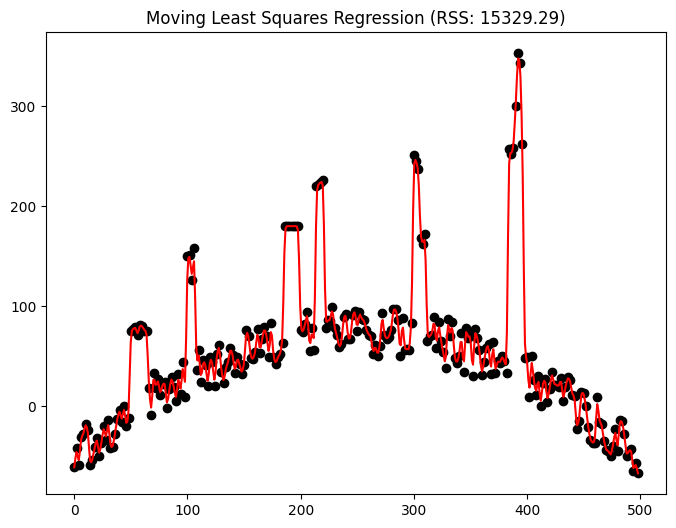

In [47]:
x_dense, y_dense = moving_least_squares(X_reshape, y)
rss = np.sum((y - np.interp(X_reshape, x_dense, y_dense)) ** 2)

plt.figure(figsize=(8, 6))
plt.plot(x_dense, y_dense, color='red')
plt.scatter(X, y, color='black')
plt.title(f"Moving Least Squares Regression (RSS: {rss:.2f})")
plt.show()

# 4. Remove Outliers

In [48]:
poly = PolynomialFeatures(degree=2)
X_poly = poly.fit_transform(X)

model = LinearRegression().fit(X_poly, y)
y_pred = model.predict(X_poly)

residuals = y - y_pred
std_residuals = np.std(residuals)

outliers = np.abs(residuals) > std_residuals

X_clean = X[~outliers]
y_clean = y[~outliers]

print("이상치 제거 후 데이터 개수:", len(X_clean))

이상치 제거 후 데이터 개수: 214


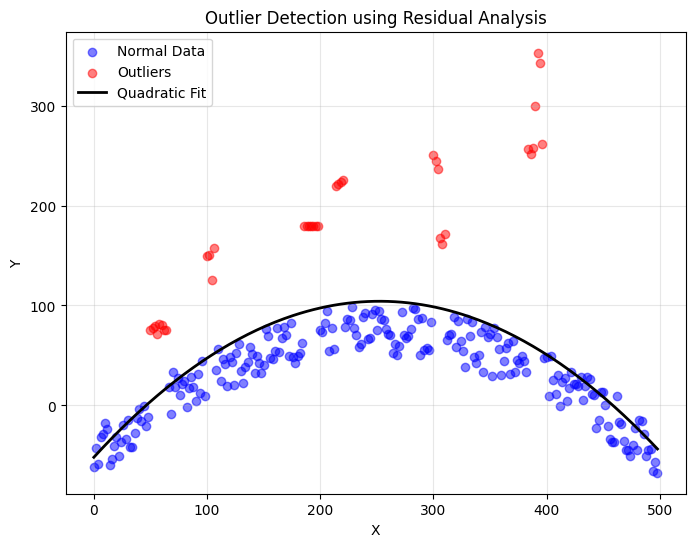

In [49]:
plt.figure(figsize=(8, 6))
plt.scatter(X_clean, y_clean, color="blue", alpha=0.5, label="Normal Data")
plt.scatter(X[outliers], y[outliers], color="red", alpha=0.5, label="Outliers")
plt.plot(X, y_pred, color="black", linewidth=2, label="Quadratic Fit")

plt.xlabel("X")
plt.ylabel("Y")
plt.title("Outlier Detection using Residual Analysis")
plt.legend()
plt.grid(True, alpha=0.3)
plt.show()

# 5.  Linear Regression without Outliers

In [50]:
lr = LinearRegression().fit(X_clean, y_clean)
hr = HuberRegressor().fit(X_clean, y_clean)
rr = RANSACRegressor().fit(X_clean, y_clean)
tsr = TheilSenRegressor().fit(X_clean, y_clean)

models = {
    "Linear": (lr, "blue"),
    "Huber": (hr, "darkorange"),
    "RANSAC": (rr, "green"),
    "Theil-Sen": (tsr, "red")
}

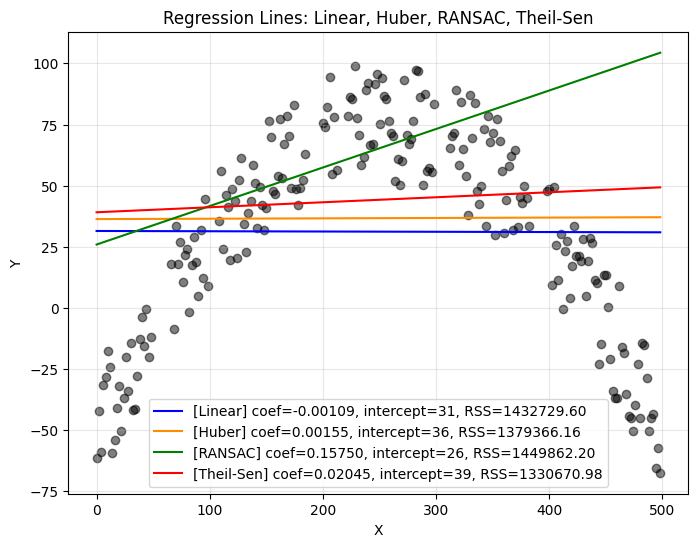

In [51]:
plt.figure(figsize=(8, 6))

for name, (model, color) in models.items():
    y_pred = model.predict(X)
    rss = np.sum((y - y_pred) ** 2)

    if name != "RANSAC":
      coef =  model.coef_[0]
      intercept = model.intercept_
    else:
      coef = model.estimator_.coef_[0]
      intercept = model.estimator_.intercept_

    label = f"[{name}] coef={coef:.5f}, intercept={intercept:.0f}, RSS={rss:.2f}"
    plt.plot(X, y_pred, color=color, label=label)

plt.scatter(X_clean, y_clean, color="black", alpha=0.5)
plt.xlabel("X")
plt.ylabel("Y")
plt.title("Regression Lines: Linear, Huber, RANSAC, Theil-Sen")
plt.grid(True, alpha=0.3)
plt.legend()
plt.show()

# 6.  Nonlinear Regression without Outliers

### (1) Polynomial Regression

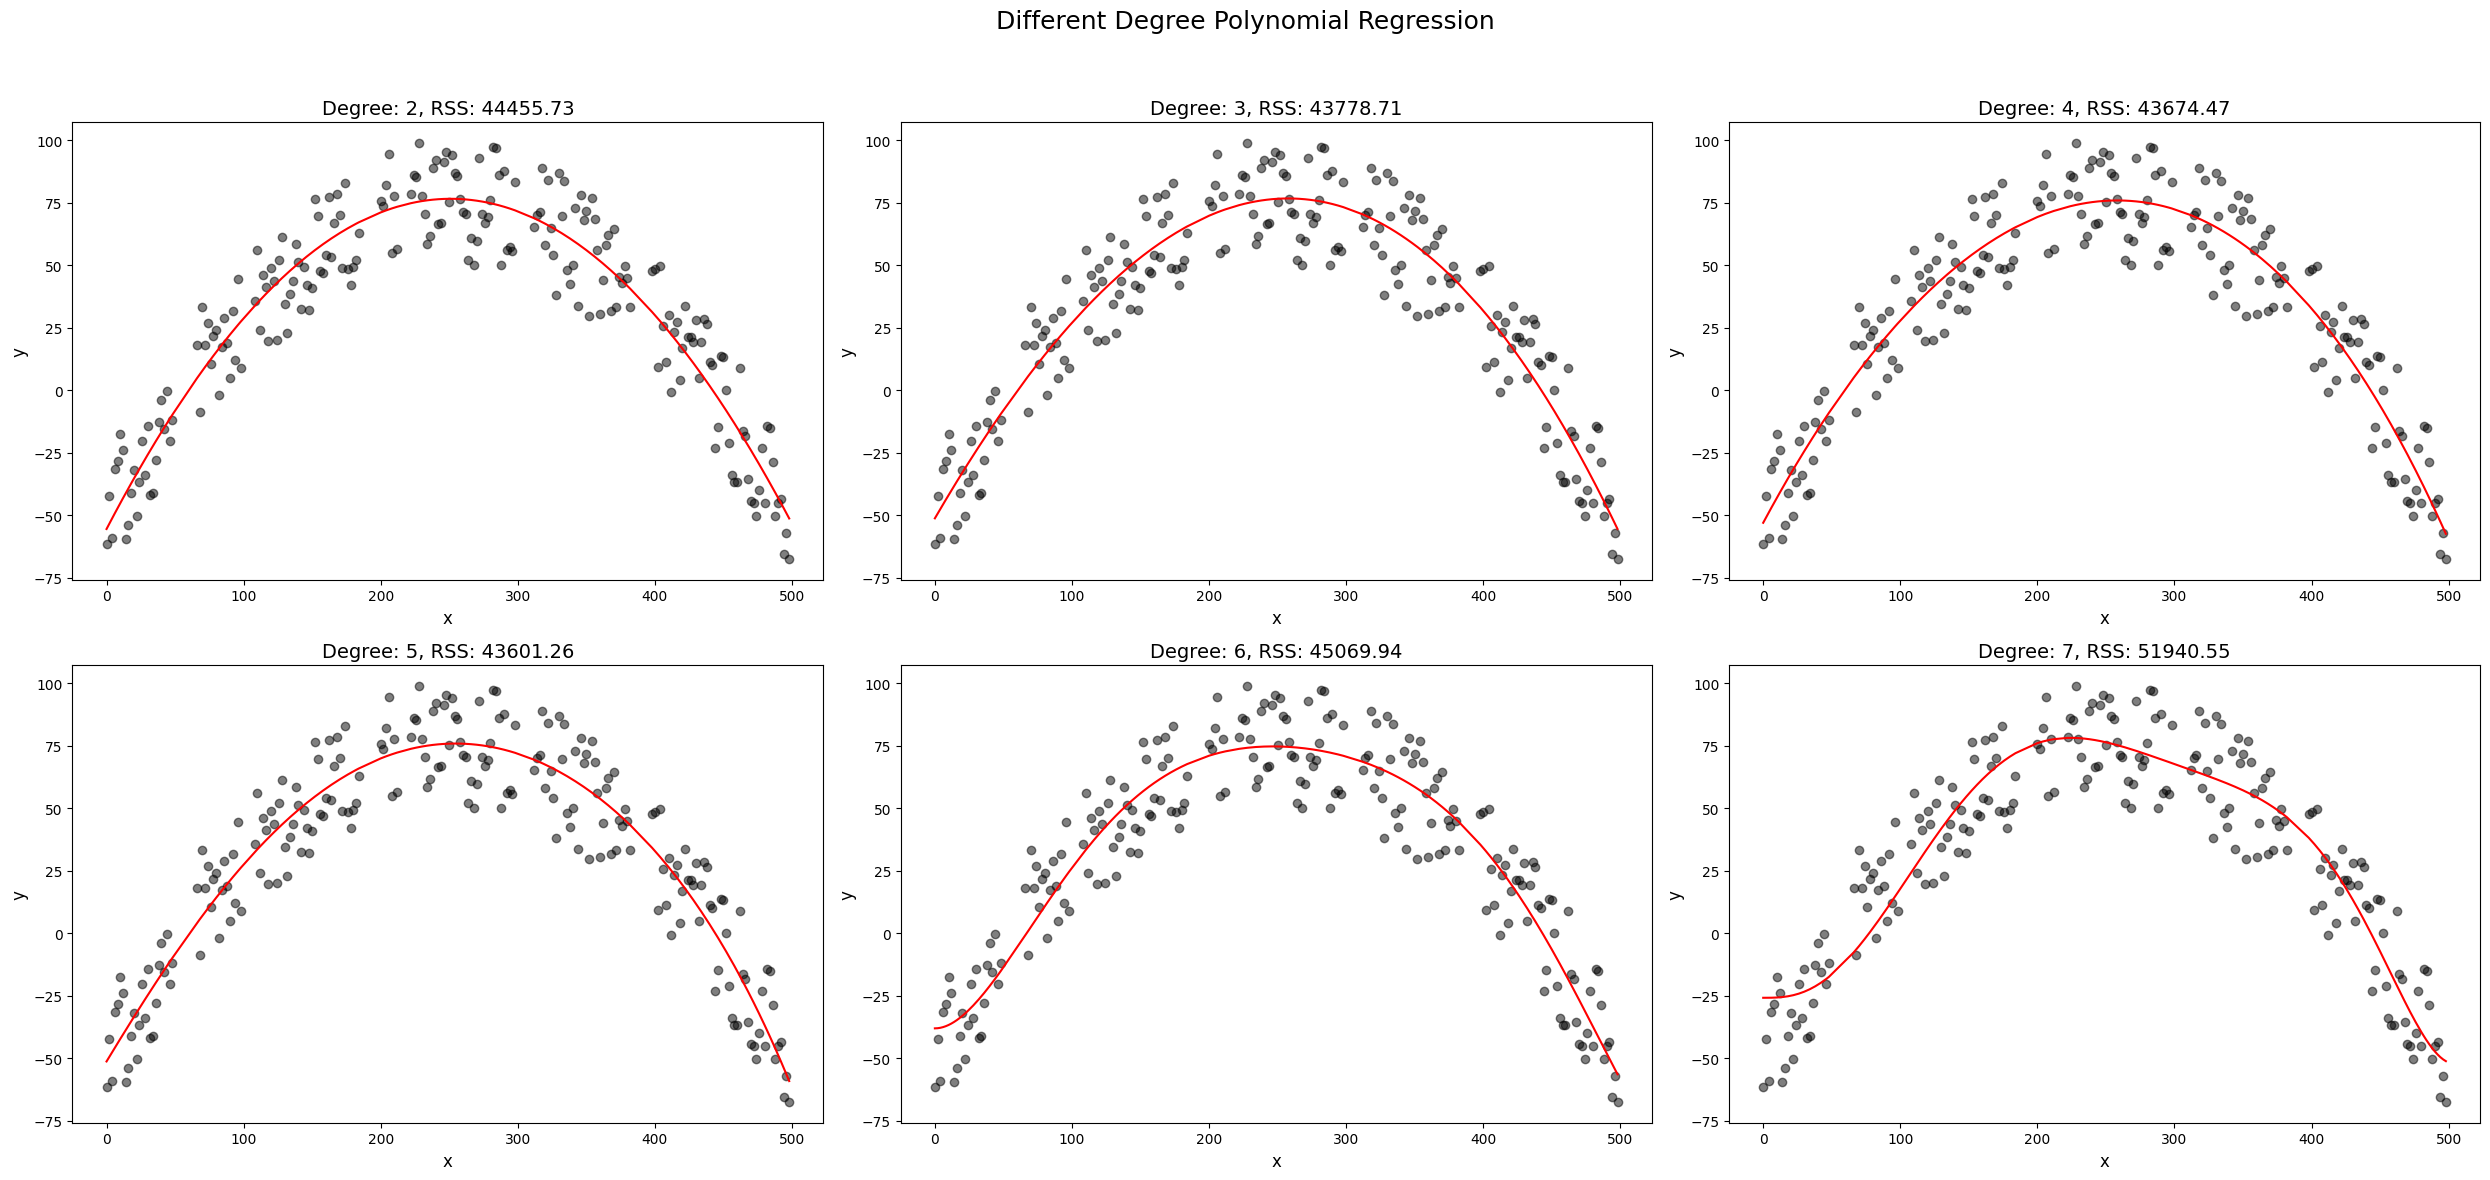

In [52]:
fig, axs = plt.subplots(2, 3, figsize=(25, 12))

for ax, degree in zip(axs.flatten(), range(2, 8)):
    poly_model = make_pipeline(PolynomialFeatures(degree), LinearRegression())
    poly_model.fit(X_clean, y_clean)

    y_train_pred = poly_model.predict(X_clean)
    rss = np.sum((y_clean - y_train_pred) ** 2)

    ax.scatter(X_clean, y_clean, color='black', alpha=0.5)
    ax.plot(X_clean, y_train_pred, color='red')

    ax.set_title(f"Degree: {degree}, RSS: {rss:.2f}", fontsize=14)
    ax.set_xlabel('x', fontsize=12)
    ax.set_ylabel('y', fontsize=12)

fig.suptitle("Different Degree Polynomial Regression", fontsize=18)
plt.tight_layout(rect=[0, 0, 1, 0.95])
plt.show()

### (2) Piecewise Lienar Regression

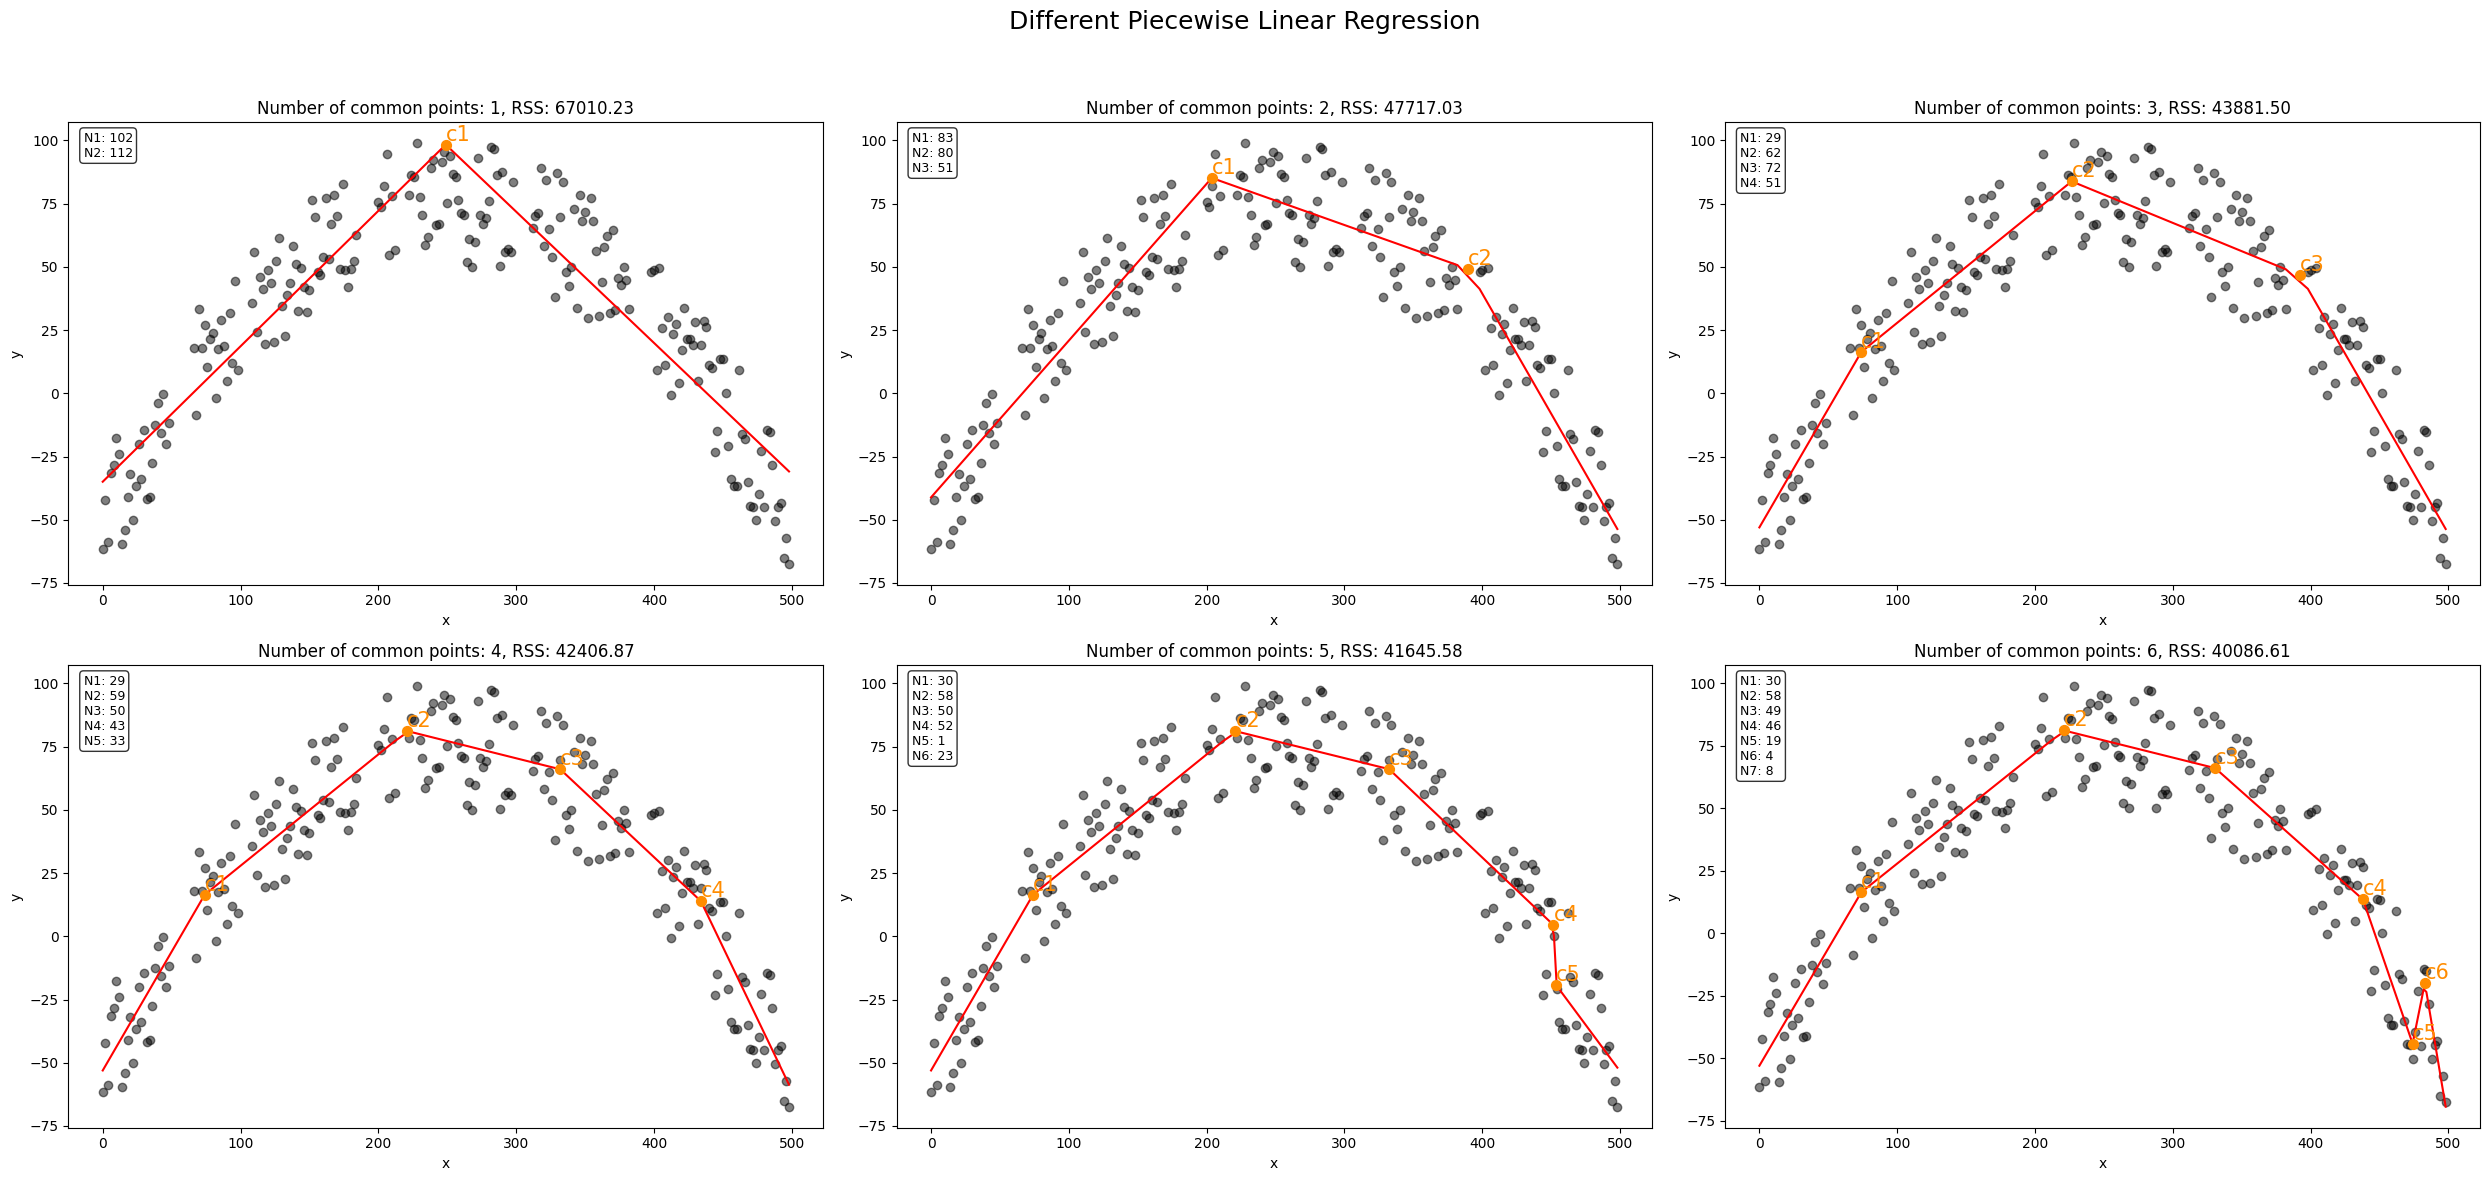

In [53]:
X_clean_reshpae = X_clean.reshape(-1)
model = pwlf.PiecewiseLinFit(X_clean_reshpae, y_clean)

fig, axs = plt.subplots(2, 3, figsize=(25, 12))
for ax, num_segments in zip(axs.flatten(), range(2, 8)):
    breakpoints = model.fit(num_segments)
    predictions = model.predict(X_clean_reshpae)

    residuals = y_clean - predictions
    RSS = np.sum(residuals ** 2)

    segment_counts = np.histogram(X_clean_reshpae, bins=breakpoints)[0]

    ax.plot(X_clean_reshpae, predictions, color='red')
    ax.scatter(X_clean_reshpae, y_clean, color='black', alpha=0.5)

    for i, bp in enumerate(breakpoints[1:-1]):
        ax.scatter(bp, model.predict([bp]), color='darkorange', s=50, zorder=5)
        ax.text(bp, model.predict([bp]), f'c{i+1}', color='darkorange', fontsize=15, verticalalignment='bottom')

    ax.set_title(f'Number of common points: {num_segments-1}, RSS: {RSS:.2f}')
    ax.set_xlabel('x')
    ax.set_ylabel('y')

    textstr = "\n".join([f'N{i+1}: {count}' for i, count in enumerate(segment_counts)])
    ax.text(0.02, 0.98, textstr, transform=ax.transAxes, fontsize=9, verticalalignment='top', bbox=dict(boxstyle='round', facecolor='white', alpha=0.8))

fig.suptitle("Different Piecewise Linear Regression", fontsize=18)
plt.tight_layout(rect=[0, 0, 1, 0.95])
plt.show()

### (3) Moving Least Squares Regression

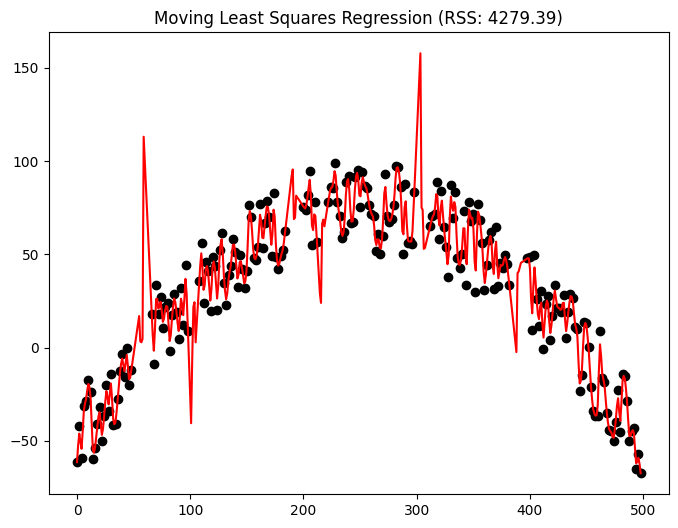

In [54]:
x_dense, y_dense = moving_least_squares(X_clean_reshpae, y_clean)
rss = np.sum((y_clean - np.interp(X_clean_reshpae, x_dense, y_dense)) ** 2)

plt.figure(figsize=(8, 6))
plt.plot(x_dense, y_dense, color='red')
plt.scatter(X_clean_reshpae, y_clean, color='black')
plt.title(f"Moving Least Squares Regression (RSS: {rss:.2f})")
plt.show()